In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engineering import process_categorical_columns

In [2]:
df = pd.read_csv('StudentPerformanceFactorsCleaned.csv')
df = process_categorical_columns(df)

In [3]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities_Yes,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access_Yes,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type_Public,Peer_Influence,Physical_Activity,Learning_Disabilities_Yes,Parental_Education_Level,Gender_Male,Exam_Score
0,23,84,Low,High,0,7,73,Low,1,0,Low,Medium,1,Positive,3,0,High School,1,67
1,19,64,Low,Medium,0,8,59,Low,1,2,Medium,Medium,1,Negative,4,0,College,0,61
2,24,98,Medium,Medium,1,7,91,Medium,1,2,Medium,Medium,1,Neutral,4,0,Postgraduate,1,74
3,29,89,Low,Medium,1,8,98,Medium,1,1,Medium,Medium,1,Negative,4,0,High School,1,71
4,19,92,Medium,Medium,1,6,65,Medium,1,3,Medium,High,1,Neutral,4,0,College,0,70


## PCA

Let's apply principal component analysis (PCA) to the numeric features in our dataset using singular value decomposition (SVD).

In [4]:
df_numeric_features = df[['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']]

In [5]:
svd_U, svd_D, svd_V = np.linalg.svd(df_numeric_features)

In [6]:
# Singular values
svd_D

array([9029.89152592, 1064.09250183,  503.90521423,  134.23917965,
         99.77387677,   85.16882642])

In [7]:
# Right singular vectors
svd_V

array([[-0.17696621, -0.71396632, -0.06208453, -0.67395773, -0.01320245,
        -0.02621527],
       [ 0.03549344,  0.68044287,  0.01434909, -0.73176747,  0.00477989,
         0.00503364],
       [-0.9819664 ,  0.15629393, -0.04070408,  0.0967583 , -0.00513617,
        -0.01639583],
       [ 0.05479388,  0.05128464, -0.98011704,  0.0294575 , -0.0893996 ,
        -0.15772786],
       [-0.00442629, -0.00893276, -0.11119152, -0.00338825,  0.98556184,
         0.12725345],
       [-0.01196657, -0.01057843, -0.14591035, -0.00747962, -0.14301063,
         0.97874771]])

In [8]:
pca = df_numeric_features@svd_V.T
pca.columns = ["Principal Component " + str(i+1) for i in range(pca.shape[1])]
pca.head()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6
0,-113.755545,4.670069,-2.727298,0.384564,-1.496080,0.205039
1,-89.447651,1.192925,-3.347299,-2.589354,0.734902,1.116005
2,-136.111899,1.074541,0.193832,1.351050,0.411824,0.603068
3,-135.337620,-9.984780,-5.480905,0.478943,-0.650384,0.583184
4,-113.371487,15.830802,1.685753,0.894195,1.672400,0.923741


Now let's try to determine how many principal components we should use to best describe these numeric features in the simplest representation.

In [9]:
pc_var_explained = np.square(svd_D) / np.square(svd_D).sum()

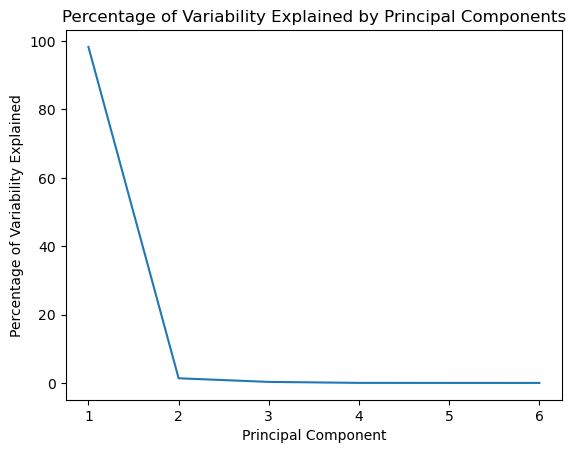

In [10]:
plt.plot(range(1, len(pc_var_explained) + 1),
         pc_var_explained * 100)
plt.xlabel("Principal Component")
plt.ylabel("Percentage of Variability Explained")
plt.title("Percentage of Variability Explained by Principal Components")
plt.show()

In [11]:
pd.DataFrame({
    "Principal Component": range(1, len(pc_var_explained) + 1),
    "Variability Explained": pc_var_explained,
    "Cumulative Variability Explained": pc_var_explained.cumsum()
})

,Principal Component,Variability Explained,Cumulative Variability Explained
0,1,0.982866,0.982866
1,2,0.013649,0.996515
2,3,0.003061,0.999575
3,4,0.000217,0.999793
4,5,0.000120,0.999913
5,6,0.000087,1.000000


As shown in both the scree plot and the table of variability explained, the first principal component captures nearly all (98.29%) of the variability in these features, so we can just use the first principal component (only one variable in a model) to describe these 6 numeric features. That's a pretty good reduction!!

In [12]:
df_numeric_features.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity
0,23,84,7,73,0,3
1,19,64,8,59,2,4
2,24,98,7,91,2,4
3,29,89,8,98,1,4
4,19,92,6,65,3,4


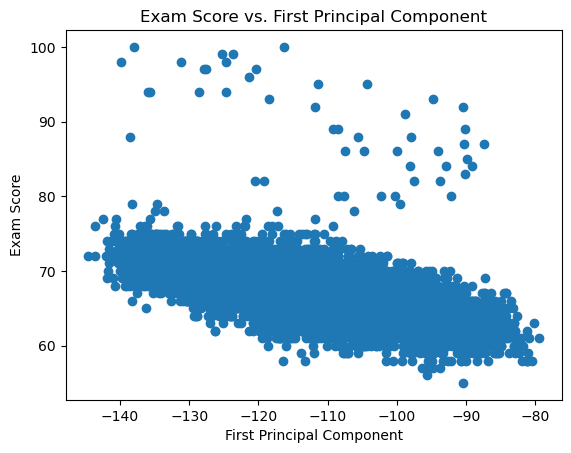

In [13]:
plt.scatter(pca['Principal Component 1'],
            df['Exam_Score']
           )
plt.xlabel('First Principal Component')
plt.ylabel('Exam Score')
plt.title('Exam Score vs. First Principal Component')
plt.show()

From this plot, we can see a slightly negative linear relationship between students' exam score and the first principal component of the 6 numeric features.

In [15]:
df = df.drop(columns = df_numeric_features.columns)
df['Numeric PC'] = pca['Principal Component 1']

In [48]:
np.corrcoef(df['Numeric PC'], df['Exam_Score'])

array([[ 1.        , -0.54905528],
       [-0.54905528,  1.        ]])

In [53]:
pd.concat([df_numeric_features, df['Exam_Score']], axis=1).corr()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
Hours_Studied,1.000000,-0.005249,0.014114,0.023286,-0.010631,0.002676,0.445447
Attendance,-0.005249,1.000000,-0.018384,-0.016834,0.013877,-0.026813,0.581052
Sleep_Hours,0.014114,-0.018384,1.000000,-0.022340,-0.011999,-0.003475,-0.016441
Previous_Scores,0.023286,-0.016834,-0.022340,1.000000,-0.015453,-0.009374,0.175302
Tutoring_Sessions,-0.010631,0.013877,-0.011999,-0.015453,1.000000,0.017174,0.157220
Physical_Activity,0.002676,-0.026813,-0.003475,-0.009374,0.017174,1.000000,0.023657
Exam_Score,0.445447,0.581052,-0.016441,0.175302,0.157220,0.023657,1.000000


We were able to summarize all of the numeric variables in our data with a single principal component, which is good from a dimensionality reduction perspective. However, this does not help us when it comes to predicting the final exam score, as the correlation between the first principal component and the exam score (about -0.55) is lower in magnitude than the correlation between the exam score and a single variable (notably, attendance with a correlation of about 0.58).

## Clustering Techniques

First let's apply KMeans to the numeric features in our dataset with a different number of clusters for each model.

In [90]:
scaler = StandardScaler()
numerics_scaled = scaler.fit_transform(df_numeric_features)

In [91]:
kmeans_2 = KMeans(n_clusters=2)
class_predictions_2 = kmeans_2.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [92]:
kmeans_3 = KMeans(n_clusters=3)
class_predictions_3 = kmeans_3.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [93]:
kmeans_4 = KMeans(n_clusters=4)
class_predictions_4 = kmeans_4.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [94]:
silhouette_score(numerics_scaled, class_predictions_2)

0.12795571382816967

In [95]:
silhouette_score(numerics_scaled, class_predictions_3)

0.12156631075282767

In [96]:
silhouette_score(numerics_scaled, class_predictions_4)

0.11938664336762118

Evaluating these three models, it seems like K means with 2 clusters achieves the best silhouette score, so we will use this to try to separate the data. Let's visualize all of the pairwise relationships between these numeric variables, coloring the data points by their cluster.

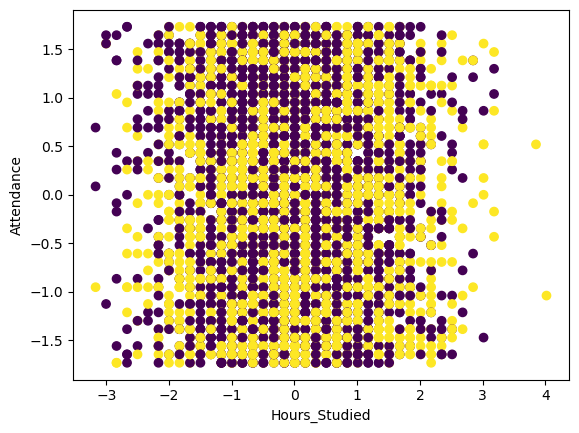

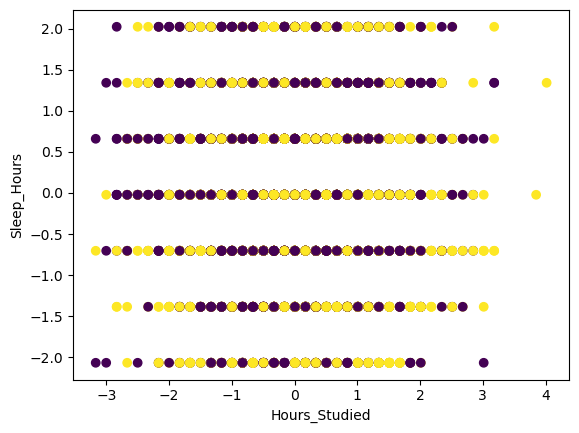

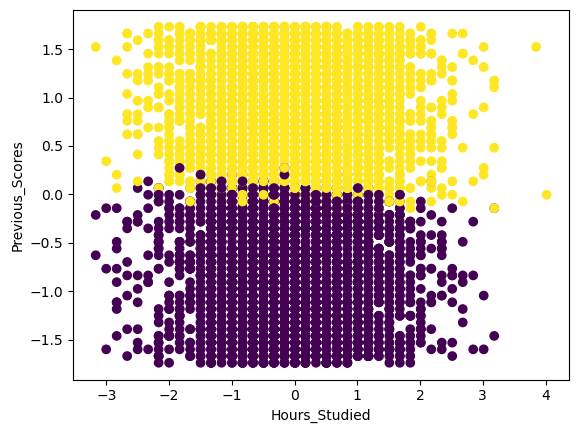

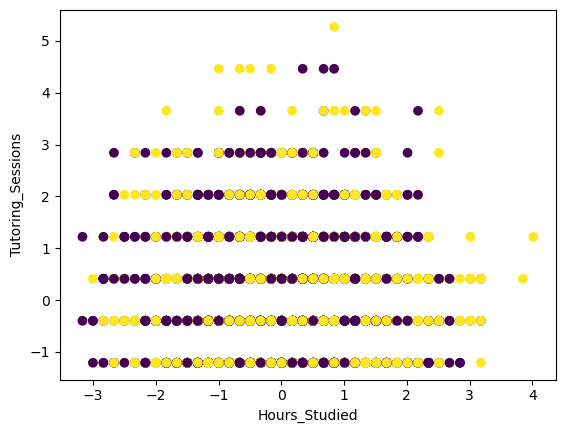

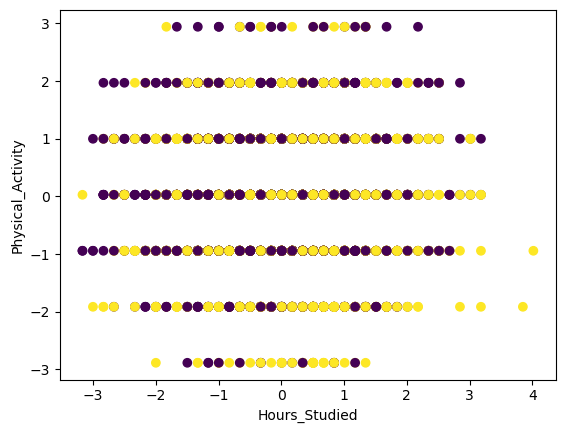

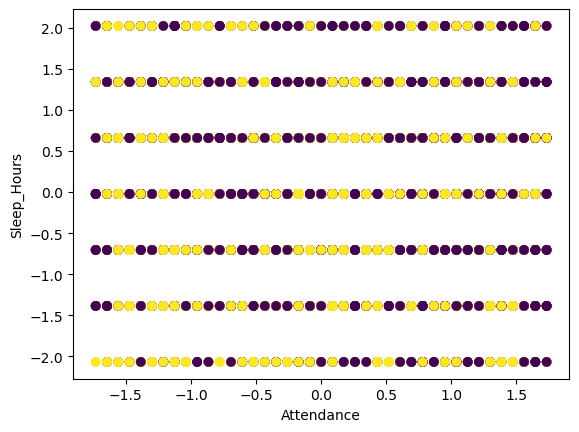

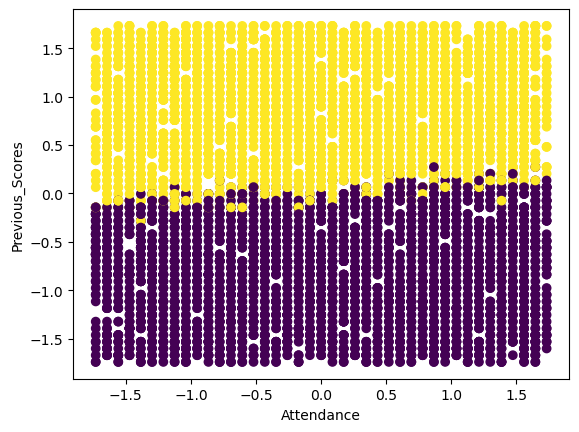

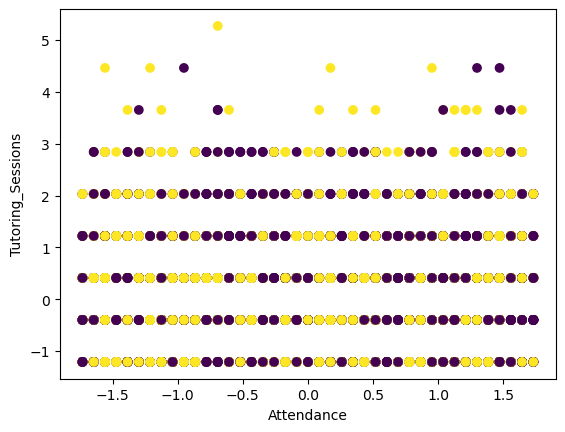

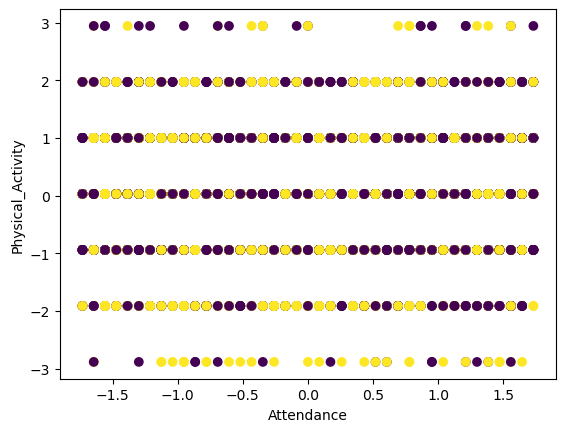

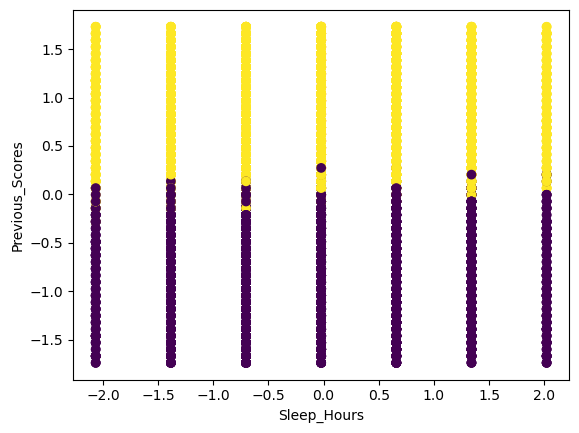

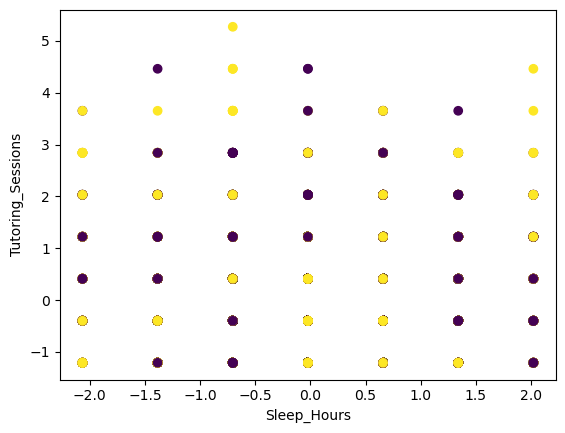

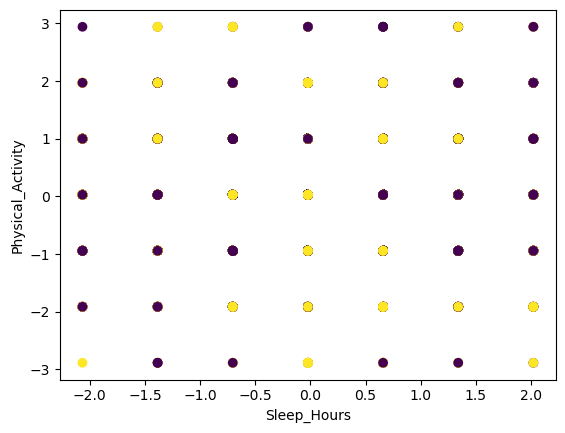

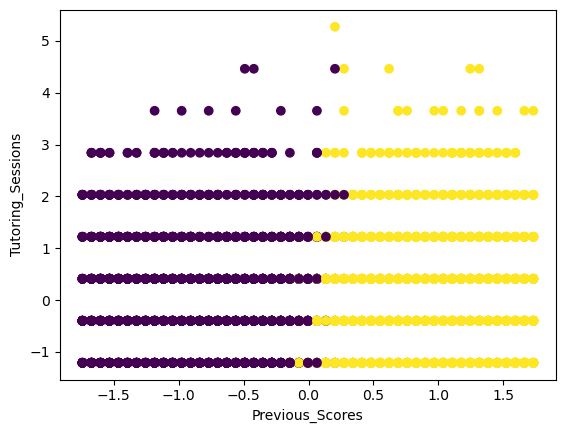

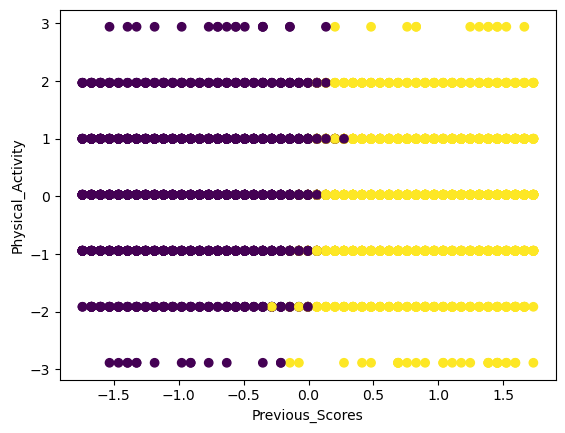

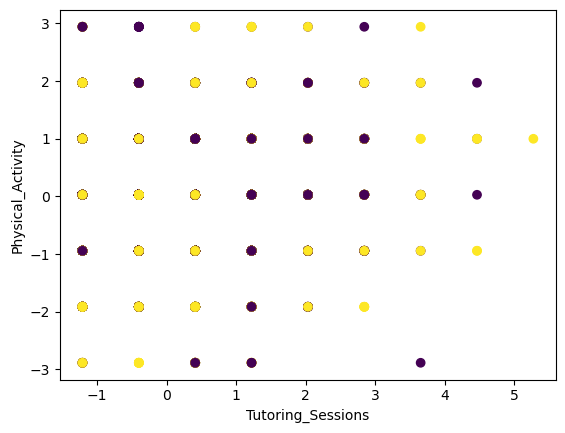

In [103]:
for i in range(numerics_scaled.shape[1]):
    for j in range(i+1, numerics_scaled.shape[1]):
        plt.scatter(numerics_scaled[:,i], numerics_scaled[:,j], c=class_predictions_2)
        plt.xlabel(df_numeric_features.columns[i])
        plt.ylabel(df_numeric_features.columns[j])
        plt.show()

As you can see in the plots above, we get very good separation of classes when visualizing previous scores vs. all other numeric features.

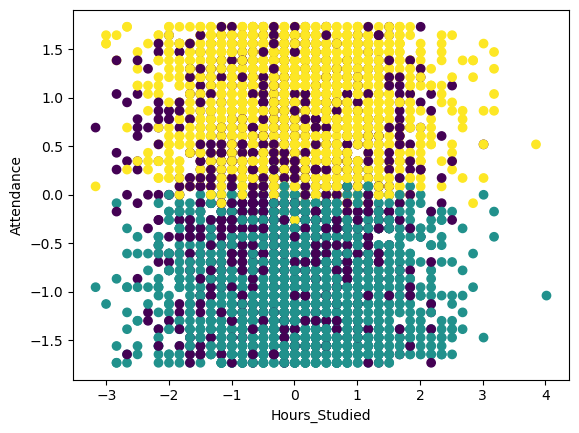

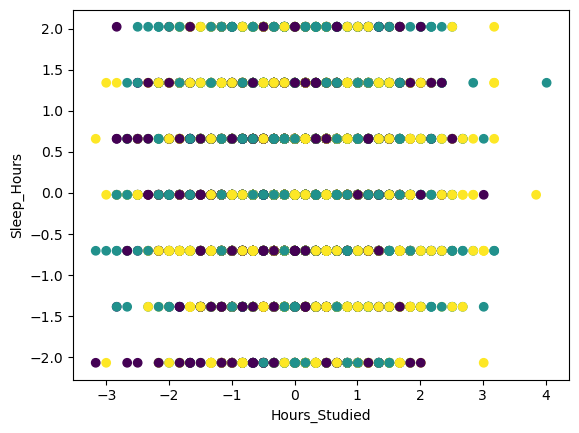

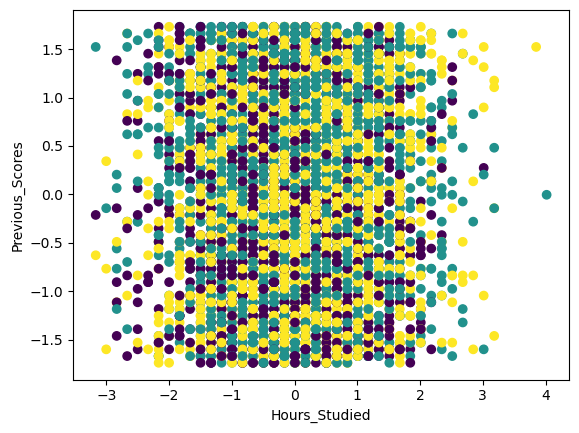

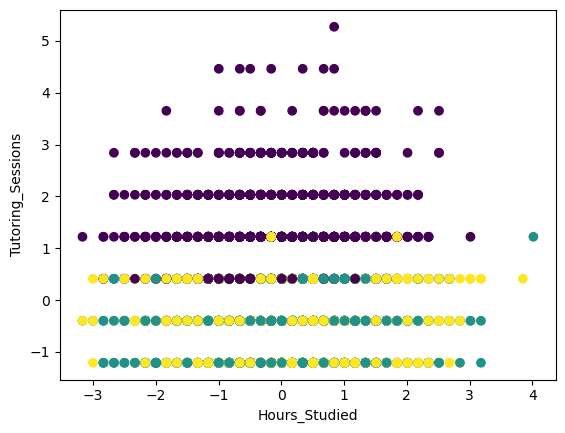

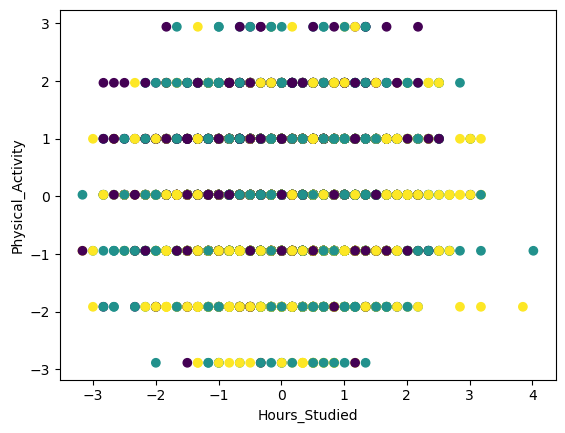

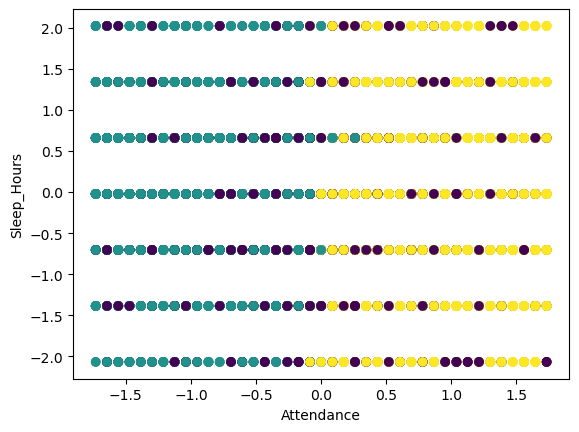

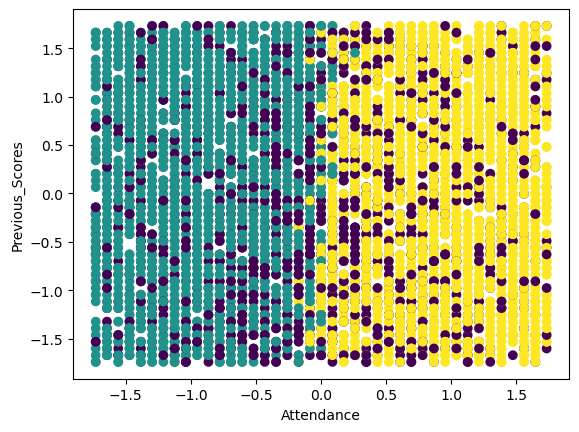

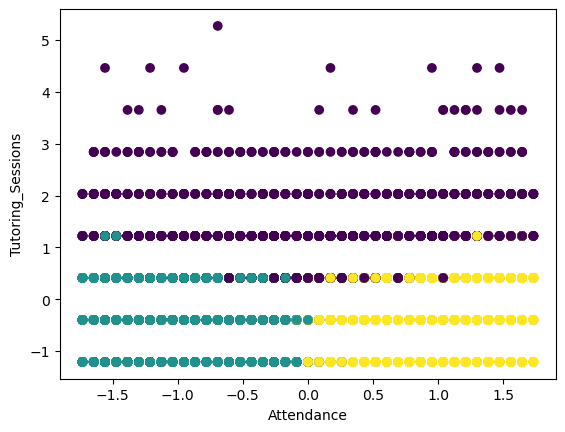

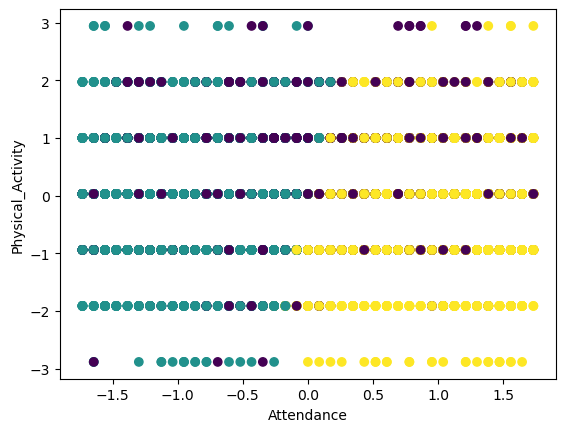

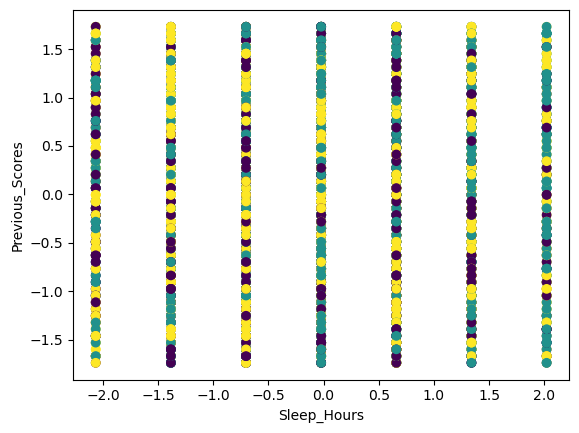

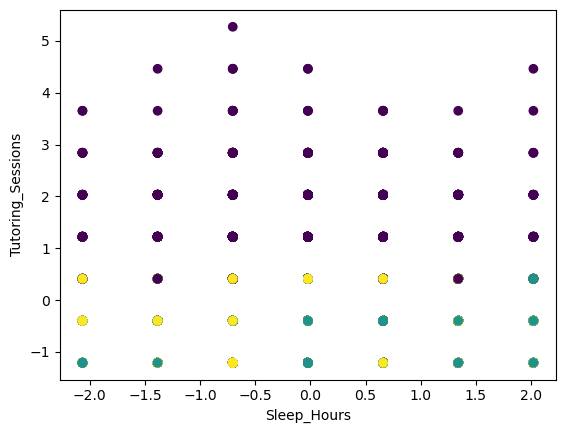

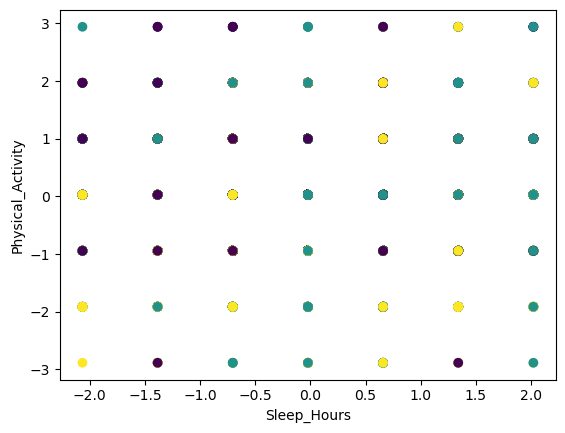

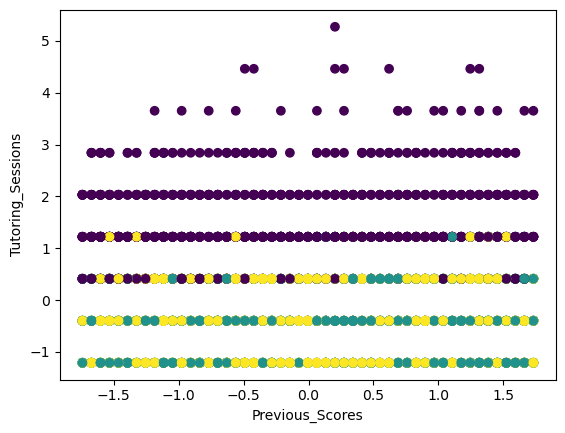

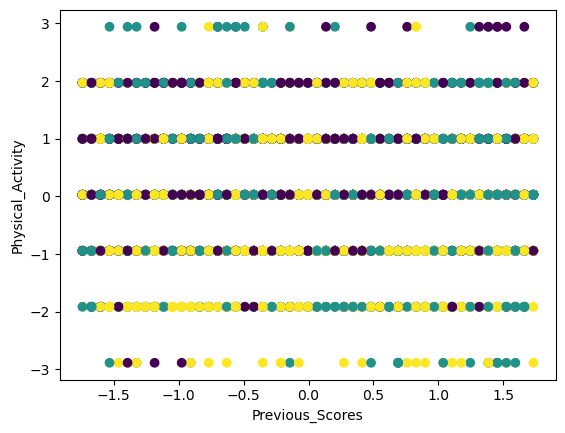

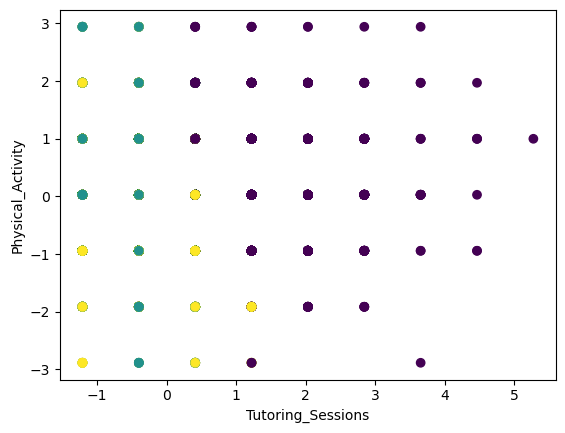

In [104]:
for i in range(numerics_scaled.shape[1]):
    for j in range(i+1, numerics_scaled.shape[1]):
        plt.scatter(numerics_scaled[:,i], numerics_scaled[:,j], c=class_predictions_3)
        plt.xlabel(df_numeric_features.columns[i])
        plt.ylabel(df_numeric_features.columns[j])
        plt.show()

If we look at the same pairwise plots for K=3, we see different kinds of separations with other variables besides the previous scores. Thus, it may actually be better to use K=3 to separate our numeric data than k=2. From this data, we could potentially describe different categories/behaviors of students. For example, the purple class above represents students who attend a lot of tutoring sessions (students who need extra support outside of class time), the yellow class represents students who have good class attendance and only attend a few tutoring sessions (students who attend class regularly and understand the course content well), and the green class represents students who have low overall class attendance and attend very few tutoring sessions (students who are either naturals and don't even need to attend class to succeed or students who don't care about the class and are simply not engaged). We may be able to use these clusters to separate our students and better understand their final exam performance.